<a href="https://colab.research.google.com/github/jihoover77/DS-Unit-2-Linear-Models/blob/master/Ridge_Regression_213_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

# I. Wrangle Data

In [ ]:
# Import Libraries I am using
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.metrics import mean_absolute_error
from category_encoders import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Read New York City property sales data

def wrangle(filepath):
  df = pd.read_csv(filepath,
                   parse_dates=['SALE DATE'],
                   index_col='SALE DATE',
                   ).sort_values(by='SALE DATE')
  
  # Drop all NaN values from the data frame

  # Change column names: replace spaces with underscores
  df.columns = [col.replace(' ', '_') for col in df]

  # SALE_PRICE was read as strings.
  # Remove symbols, convert to integer
  df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
  )
  
  # LAND_SQUARE_FEET was read as strings.
  # Remove the symbols, convert to float.
  
  # Reduce cardinality for NEIGHBORHOOD feature

  # Get a list of the top 10 neighborhoods
  top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

  # At locations where the neighborhood is NOT in the top 10, 
  # replace the neighborhood with 'OTHER'
  df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

  # BOROUGH is a numeric column, but arguably should be a categorical feature,
  # so convert it from a number to a string
  df['BOROUGH'] = df['BOROUGH'].astype(str)

  # Use a subset of the data where 
  # BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS'
  # sale price was more than 100 thousand and less than 2 million.

  class_mask = df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS'
  df = df[class_mask]

  sales_mask = (df['SALE_PRICE'] > 100000) & (df['SALE_PRICE'] < 2000000)
  df = df[sales_mask]

  # Drop features with only one type of observation and duplicate columns
  df.drop(columns=['EASE-MENT', 'APARTMENT_NUMBER', 'BUILDING_CLASS_CATEGORY',
                  'LAND_SQUARE_FEET'], inplace=True)

  # Drop high cardinality categorical features
  threshold = 10
  drop_cols = [col for col in df.select_dtypes('object').columns
             if df[col].nunique() >= threshold]
  df.drop(columns=drop_cols, inplace=True)

  return df

df = wrangle(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3151 entries, 2019-01-01 to 2019-04-30
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   BOROUGH                    3151 non-null   object 
 1   NEIGHBORHOOD               3151 non-null   object 
 2   TAX_CLASS_AT_PRESENT       3151 non-null   object 
 3   BLOCK                      3151 non-null   int64  
 4   LOT                        3151 non-null   int64  
 5   ZIP_CODE                   3151 non-null   float64
 6   RESIDENTIAL_UNITS          3151 non-null   float64
 7   COMMERCIAL_UNITS           3151 non-null   float64
 8   TOTAL_UNITS                3151 non-null   float64
 9   GROSS_SQUARE_FEET          3151 non-null   float64
 10  YEAR_BUILT                 3151 non-null   float64
 11  TAX_CLASS_AT_TIME_OF_SALE  3151 non-null   int64  
 12  SALE_PRICE                 3151 non-null   int64  
dtypes: float64(6), int64(4), objec

# II. Train/Test Split

In [ ]:
#  Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test
target = 'SALE_PRICE'
y = df[target]
X = df.drop(columns=target)

In [ ]:
cutoff = '2019-04-01'
mask = df.index < '2019-04-01'
X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2507, 12), (2507,), (644, 12), (644,))

# III. Establish Baseline

In [ ]:
y_pred = [y_train.mean()] * (len(y_train))

print('Baseline Mean: ', round(y_train.mean()))
print('Baseline MAE: ', round(mean_absolute_error(y_train, y_pred)))

Baseline Mean:  621574
Baseline MAE:  214722


# IV. Build Models

## A. Use One Hot Encoding on the categorical features

In [ ]:
# Step 1: Import transformer
# Done

# Step 2: Intantiate the tranformer
ohe = OneHotEncoder(use_cat_names=True)

# Step 3:  Fit the transformer to the TRAINING data
ohe.fit(X_train)

# Step 4:  Transform my training and test data
XT_train = ohe.fit_transform(X_train)
XT_test = ohe.transform(X_test)


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


## B. Use SelectKBest to select features that are optimal for this data set


In [ ]:
# Step 1:  Import selector
# Done

# Step 2:  Instantiate the selector
selector = SelectKBest(score_func=f_regression)

# Step 3:  Fit the selector to TRAINING data
selector.fit(XT_train, y_train)

# Step 4:  Transform the training and test data
XTT_train = selector.fit_transform(XT_train, y_train)
XTT_test = selector.transform(XT_test)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


## C. Choose our predictor class

### Linear Regression Model

In [ ]:
# Step 1:  Import predictor
# Done

# Step 2:  Instantiate the predictor
model_lr = LinearRegression()

# Step 3:  Fit the model to the TRAINING data
model_lr.fit(XT_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Ridge Regression

In [ ]:
model_r = Ridge(alpha=1.0)
model_r.fit(XT_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

### Ridge Regression Model with SelectKBest

In [ ]:
model_r_skbest = Ridge(alpha=1.0)
model_r_skbest.fit(XTT_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

# V. Check Metrics

In [ ]:
print(f'Baseline Mean: ${y_train.mean():,.0f}')
print(f'Baseline MAE: ${mean_absolute_error(y_train, y_pred):,.0f}')

Baseline Mean: $621,574
Baseline MAE: $214,722


In [ ]:
print(f'LR training MAE: ${mean_absolute_error(y_train, (model_lr.predict(XT_train))):,.0f}')
print(f'LR testing MAE: ${mean_absolute_error(y_test, (model_lr.predict(XT_test))):,.0f}')

LR training MAE: $158,445
LR testing MAE: $162,021


In [ ]:
print(f'Ridge training MAE:  ${mean_absolute_error(y_train, model_r.predict(XT_train)):,.0f}')
print(f'Ridge testing MAE:  ${mean_absolute_error(y_test, model_r.predict(XT_test)):,.0f}')

Ridge training MAE:  $158,434
Ridge testing MAE:  $161,908


In [ ]:
print(f'Ridge training MAE:  ${mean_absolute_error(y_train, model_r_skbest.predict(XTT_train)):,.0f}')
print(f'Ridge testing MAE:  ${mean_absolute_error(y_test, model_r_skbest.predict(XTT_test)):,.0f}')

Ridge training MAE:  $161,536
Ridge testing MAE:  $162,073


# Communicate results

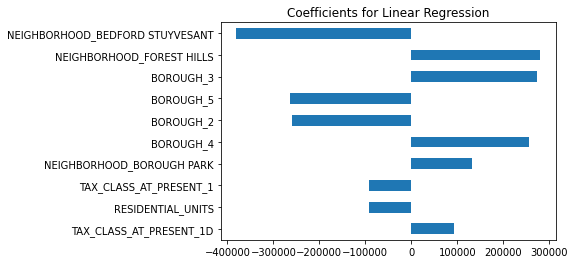

In [ ]:
%matplotlib inline
coefficents = model_lr.coef_
features = ohe.get_feature_names()
feat_imp = pd.Series(coefficents, index=features).sort_values(key=abs)
feat_imp.tail(10).plot(kind='barh')
plt.title('Coefficients for Linear Regression')
plt.show()

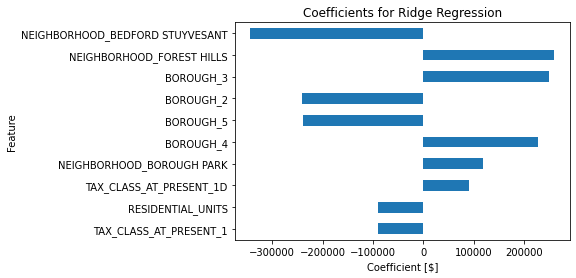

In [ ]:
coefficients = model_r.coef_
features = ohe.get_feature_names()
feat_imp = pd.Series(coefficients, index=features).sort_values(key=abs)
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Coefficient [$]')
plt.ylabel('Feature')
plt.title('Coefficients for Ridge Regression')
plt.show()

In [ ]:
pipeline = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    RidgeCV(alphas=(0.1, 1.0, 10.0, 100.0))
)

pipeline.fit(XT_train, y_train);

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [ ]:
print(f'Ridge CV Training MAE:  ${mean_absolute_error(y_train, pipeline.predict(XT_train)):,.0f}')
print(f'Ridge CV Testing MAE:  ${mean_absolute_error(y_test, pipeline.predict(XT_test)):,.0f}')

Ridge CV Training MAE:  $158,443
Ridge CV Testing MAE:  $161,971
